In [2]:
import sys
sys.executable

'c:\\Users\\carlo\\miniforge3\\envs\\dtu02452\\python.exe'

In [3]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch
from IPython.display import display
from scipy.signal import welch
from scipy.signal import coherence


In [4]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\n3.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()
raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]

Reading 0 ... 16927231  =      0.000 ... 33060.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_36396\716928837.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_36396\716928837.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


(512.0,
 23,
 ['Fp2-F4',
  'F4-C4',
  'C4-P4',
  'P4-O2',
  'F8-T4',
  'T4-T6',
  'FP1-F3',
  'F3-C3',
  'C3-P3',
  'P3-O1'])

In [5]:
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Sampling frequency: 512.0
Duration (s): 33061.0


In [6]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


In [7]:
import importlib
import functions
importlib.reload(functions)

from functions import compute_stage_epochs, add_epoch_onsets

df = add_epoch_onsets(df, 30.0)

stages = ["W", "R", "S1", "S2", "S3", "S4"]

stage_dfs = {}

for stage in stages:
    stage_dfs[stage] = compute_stage_epochs(df, stage)

stage_dfs["R"][:5]

[(13620.0, 13650.0),
 (13650.0, 13680.0),
 (13680.0, 13710.0),
 (13710.0, 13740.0),
 (13740.0, 13770.0)]

In [8]:
wake_epochs = compute_stage_epochs(df, "W")
rem_epochs  = compute_stage_epochs(df, "R")
S1_epochs   = compute_stage_epochs(df, "S1")
S2_epochs   = compute_stage_epochs(df, "S2")
S3_epochs   = compute_stage_epochs(df, "S3")
S4_epochs   = compute_stage_epochs(df, "S4")

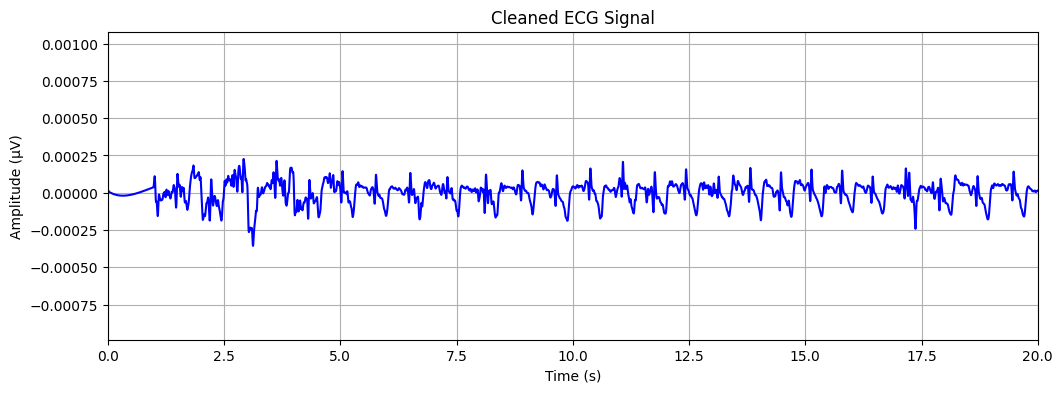

In [16]:
import functions
from functions import preprocess_ecg

ecg_clean = preprocess_ecg(raw)
sf = raw.info["sfreq"]

fig, ax = plt.subplots(figsize=(12, 4))
time = np.arange(len(ecg_clean)) / sf
ax.plot(time, ecg_clean, color='blue')
ax.set_title("Cleaned ECG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (µV)")
ax.set_xlim(0, 20) 
ax.grid()
plt.show()


In [18]:
import importlib
import functions
importlib.reload(functions)

from functions import extract_ecg_per_epoch

ecg_R  = extract_ecg_per_epoch(ecg_clean, ecg_clean, rem_epochs, sf)
ecg_S1 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S1_epochs, sf)
ecg_S2 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S2_epochs, sf)
ecg_S3 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S3_epochs, sf)
ecg_S4 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S4_epochs, sf)
ecg_W  = extract_ecg_per_epoch(ecg_clean, ecg_clean, wake_epochs, sf)

In [20]:
ecg_R["hr_mean_bpm"].mean()
ecg_S2["hr_mean_bpm"].mean()

KeyError: 'hr_mean_bpm'

In [ ]:
def concat_clean_stage(df_stage, sf, gap_s=2.0):
    gap = np.full(int(gap_s * sf), np.nan)
    parts = []
    for _, r in df_stage[df_stage["ok"]].iterrows():
        parts.append(r["clean_seg"])
        parts.append(gap)
    return np.concatenate(parts[:-1]) if len(parts) else np.array([])

ecg_clean_rem  = concat_clean_stage(ecg_R, sf)
ecg_clean_s1   = concat_clean_stage(ecg_S1, sf)
ecg_clean_s2   = concat_clean_stage(ecg_S2, sf)
ecg_clean_s3   = concat_clean_stage(ecg_S3, sf)
ecg_clean_s4   = concat_clean_stage(ecg_S4, sf)
ecg_clean_wake = concat_clean_stage(ecg_W, sf)


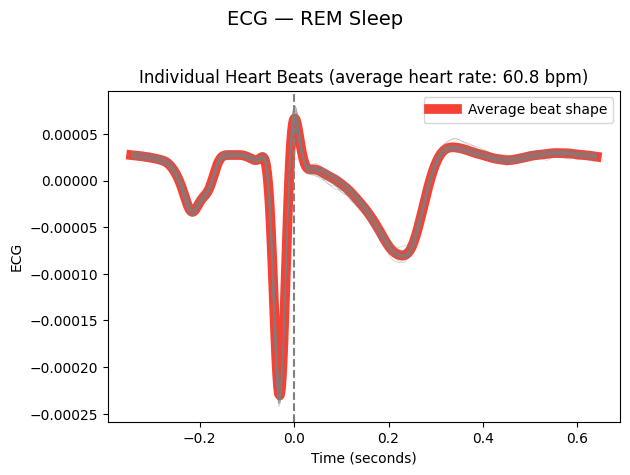

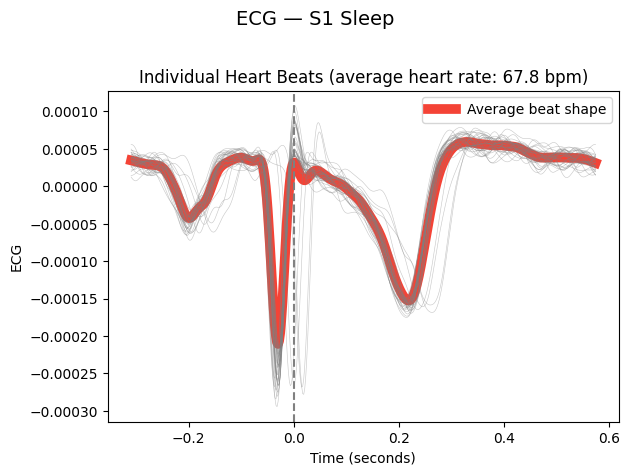

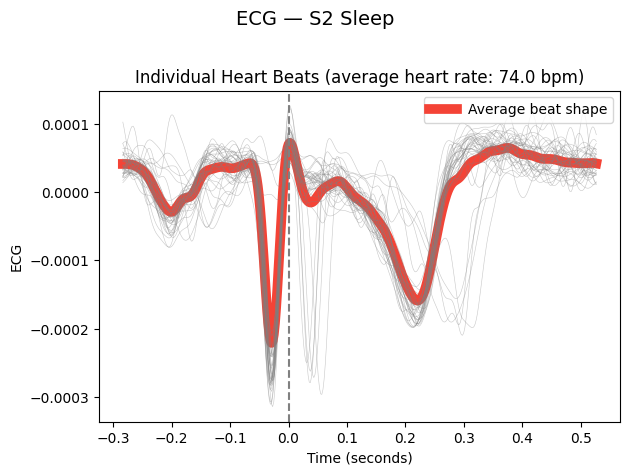

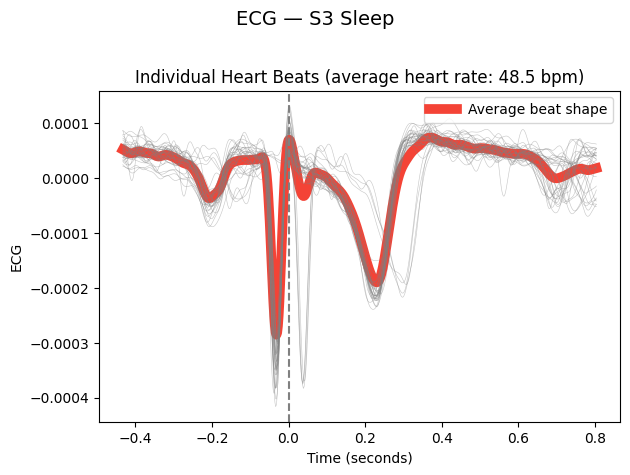

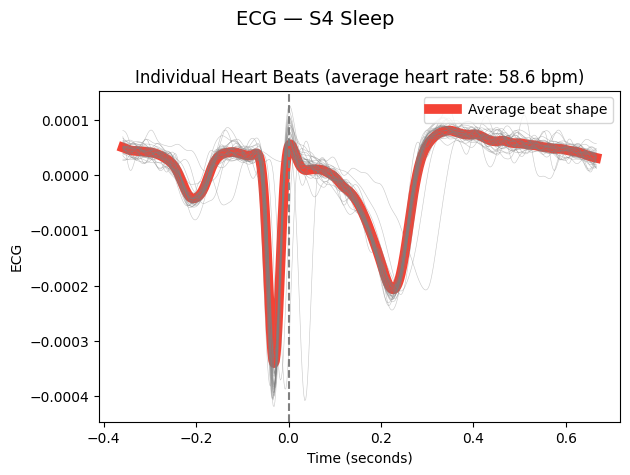

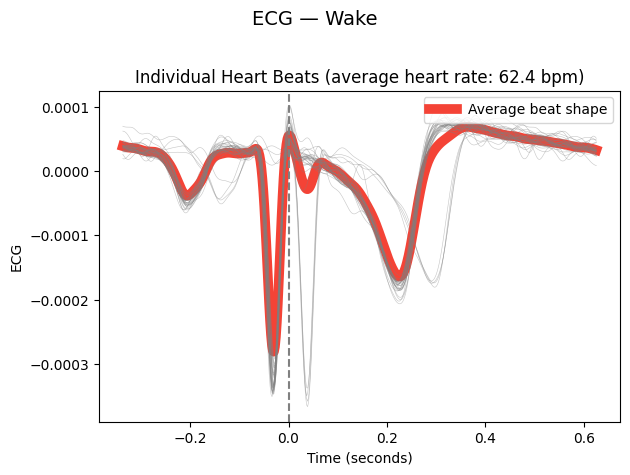

In [ ]:
# Indivudual Heart Beat - REM Sleep
nk.ecg_segment(ecg_clean_rem, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — REM Sleep", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Indivudual Heart Beat - S1 Sleep
nk.ecg_segment(ecg_clean_s1, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — S1 Sleep", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Indivudual Heart Beat - S2 Sleep
nk.ecg_segment(ecg_clean_s2, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — S2 Sleep", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Indivudual Heart Beat - S3 Sleep
nk.ecg_segment(ecg_clean_s3, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — S3 Sleep", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Indivudual Heart Beat - S4 Sleep
nk.ecg_segment(ecg_clean_s4, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — S4 Sleep", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Indivudual Heart Beat - WAKE Sleep
nk.ecg_segment(ecg_clean_wake, rpeaks=None, sampling_rate=sf, show=True)
plt.gcf().suptitle("ECG — Wake", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

In [ ]:
def hrv_per_epoch(ecg, epochs, sf):
    rows = []
    for i, (t0, t1) in enumerate(epochs):
        a, b = int(t0*sf), int(t1*sf)
        x = ecg[a:b]
        try:
            signals, info = nk.ecg_process(x, sampling_rate=sf)
            # mean HR from ECG_Rate (bpm)
            hr_mean = float(np.nanmean(signals["ECG_Rate"]))

            # HRV metrics (time domain) from detected R-peaks
            hrv = nk.hrv_time(info, sampling_rate=sf).iloc[0].to_dict()

            rows.append({
                "epoch": i,
                "start_s": float(t0),
                "hr_mean_bpm": hr_mean,
                "rmssd_ms": float(hrv.get("HRV_RMSSD", np.nan)),
                "sdnn_ms": float(hrv.get("HRV_SDNN", np.nan)),
                "pnn50_pct": float(hrv.get("HRV_pNN50", np.nan)),
                "n_beats": int(len(info["ECG_R_Peaks"])) if "ECG_R_Peaks" in info else np.nan,
                "ok": True
            })
        except Exception as e:
            rows.append({"epoch": i, "start_s": float(t0), "ok": False, "error": str(e)})

    return pd.DataFrame(rows)


hrv_rem = hrv_per_epoch(ecg_clean_total, rem_epochs, sf)

hrv_s1 = hrv_per_epoch(ecg_clean_total, S1_epochs, sf)

hrv_s2 = hrv_per_epoch(ecg_clean_total, S2_epochs, sf)

hrv_s3 = hrv_per_epoch(ecg_clean_total, S3_epochs, sf)

hrv_s4 = hrv_per_epoch(ecg_clean_total, S4_epochs, sf)

hrv_wake = hrv_per_epoch(ecg_clean_total, wake_epochs, sf)

for name, df_ in [
    ("REM", hrv_rem),
    ("S1",  hrv_s1),
    ("S2",  hrv_s2),
    ("S3",  hrv_s3),
    ("S4",  hrv_s4),
    ("WAKE", hrv_wake),
]:
    display(df_.head(10).style.set_caption(f"HRV per epoch — {name}").format(precision=3))


c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packag

,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,13620.000,62.837,11.572,16.083,0.000,31,True
1,1,13650.000,62.521,10.322,11.634,0.000,31,True
2,2,13680.000,61.865,14.954,16.768,0.000,31,True
3,3,13710.000,61.849,12.427,19.863,0.000,31,True
4,4,13740.000,62.685,9.826,7.665,0.000,31,True
5,5,13770.000,62.174,11.037,8.679,0.000,31,True
6,6,13800.000,62.221,11.336,10.998,0.000,31,True
7,7,13830.000,62.450,10.233,11.066,0.000,31,True
8,8,13860.000,63.072,8.475,9.088,0.000,31,True
9,9,13890.000,62.450,7.263,10.021,0.000,31,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok,error
0,0,690.000,68.599,25.648,28.574,6.061,34.000,True,nan
1,1,720.000,69.664,21.548,18.178,3.030,34.000,True,nan
2,2,750.000,69.425,85.540,55.494,54.545,34.000,True,nan
3,3,780.000,60.670,549.897,355.084,33.333,7.000,True,nan
4,4,1170.000,65.749,66.736,53.353,34.375,33.000,True,nan
5,5,1260.000,67.432,88.462,109.723,32.258,32.000,True,nan
6,6,4320.000,69.902,76.219,48.796,45.455,34.000,True,nan
7,7,4350.000,68.170,92.236,63.613,33.333,7.000,True,nan
8,8,4380.000,69.758,20.507,23.931,2.941,35.000,True,nan
9,9,4410.000,67.755,20.701,28.334,0.000,11.000,True,nan


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok,error
0,0,810.000,74.818,79.519,47.906,47.222,37.000,True,nan
1,1,840.000,75.156,89.831,50.642,50.000,7.000,True,nan
2,2,870.000,79.330,3.383,3.373,0.000,9.000,True,nan
3,3,900.000,75.116,199.921,205.392,72.222,37.000,True,nan
4,4,930.000,57.018,500.109,452.531,66.667,4.000,True,nan
5,5,1200.000,60.125,108.773,81.262,51.724,30.000,True,nan
6,6,1230.000,67.604,102.100,63.056,70.370,28.000,True,nan
7,7,1290.000,63.088,60.649,49.012,36.667,31.000,True,nan
8,8,1320.000,59.506,64.590,57.244,66.667,10.000,True,nan
9,9,1350.000,61.309,94.855,78.077,51.724,30.000,True,nan


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,1560.000,62.594,71.551,108.713,33.333,31,True
1,1,1590.000,58.432,81.995,109.860,53.571,29,True
2,2,1620.000,68.199,11.591,13.120,0.000,11,True
3,3,1650.000,64.735,20.054,14.688,0.000,9,True
4,4,1680.000,63.364,53.310,46.012,22.581,32,True
5,5,1710.000,64.634,21.314,27.430,8.333,13,True
6,6,1740.000,66.887,64.666,38.105,28.125,33,True
7,7,1770.000,65.912,57.443,39.794,25.000,9,True
8,8,1800.000,64.770,9.264,8.470,0.000,14,True
9,9,1830.000,64.302,37.440,30.038,16.129,32,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,1890.000,64.275,42.404,31.530,9.677,32,True
1,1,1920.000,63.262,19.657,14.968,0.000,19,True
2,2,1950.000,63.337,28.269,36.360,6.667,31,True
3,3,1980.000,65.870,18.889,18.026,3.226,32,True
4,4,2010.000,66.520,11.500,15.411,0.000,14,True
5,5,2040.000,65.612,15.383,12.774,0.000,33,True
6,6,2070.000,63.223,212.314,147.981,6.667,31,True
7,7,2100.000,66.226,81.495,64.503,6.452,32,True
8,8,2130.000,64.846,21.429,14.286,0.000,10,True
9,9,2160.000,67.222,79.258,86.084,15.625,33,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,0.000,65.439,79.397,52.258,48.387,32,True
1,1,30.000,65.528,82.492,48.204,45.161,32,True
2,2,60.000,65.073,14.866,13.669,0.000,32,True
3,3,90.000,71.372,15.448,55.600,0.000,36,True
4,4,120.000,66.907,52.327,38.985,34.375,33,True
5,5,150.000,69.033,469.296,296.159,78.788,34,True
6,6,180.000,72.957,77.274,49.542,60.000,36,True
7,7,210.000,69.940,227.837,215.868,36.364,34,True
8,8,240.000,75.222,79.561,49.073,41.667,37,True
9,9,270.000,77.111,137.742,105.447,59.459,38,True


HPC ANLYSIS

In [ ]:
resp = raw.copy().pick(["TORACE"]).load_data().get_data()[0]

def hpc_metric(ecg, resp, epochs, sf):
    rows = []
    fs_cpc = 4  # Resample ECG and Resp to a common frequency for coherence analysis
    for i, (t0, t1) in enumerate(epochs):
        a, b = int(t0*sf), int(t1*sf)
        x_ecg = ecg[a:b]
        x_resp = resp[a:b]
        try:
             _, info = nk.ecg_peaks(x_ecg, sampling_rate=sf)
             rpeaks = info["ECG_R_Peaks"]
             rr = np.diff(rpeaks) / sf  # RR intervals in seconds
             t_rr = np.cumsum(rr)  # Time points of RR intervals
             t_grid = np.arange(t_rr[0], t_rr[-1], 1/fs_cpc)
             rr_resampled = np.interp(t_grid, t_rr, rr)  # Resample RR intervals to common grid
             t_resp_grid = np.arange(len(x_resp))/sf
             x_resp_resampled = np.interp(t_grid, t_resp_grid, x_resp)  # Resample Resp to common grid
             nps = min(64, len(rr_resampled))
             f, Cxy = coherence(rr_resampled, x_resp_resampled, fs=fs_cpc, nperseg=nps)

             lf_mask = (f >= 0.01) & (f <= 0.15)
             hf_mask = (f >= 0.15) & (f <= 0.40)
             HFC = np.trapezoid(Cxy[hf_mask], f[hf_mask])
             LFC = np.trapezoid(Cxy[lf_mask], f[lf_mask])
             LFC_HFC_ratio = LFC / HFC if HFC > 0 else np.nan
             rows.append({"epoch": i, "HFC": HFC, "LFC": LFC, "LFC/HFC": LFC_HFC_ratio, "ok": True})
        except Exception as e:
             rows.append({"epoch": i, "start_s": float(t0), "ok": False, "error": str(e)})
             continue   

    return pd.DataFrame(rows)

In [ ]:
hpc_s1 = hpc_metric(ecg_clean_total, resp, S1_epochs, sf)
hpc_s2 = hpc_metric(ecg_clean_total, resp, S2_epochs, sf)
hpc_s3 = hpc_metric(ecg_clean_total, resp, S3_epochs, sf)
hpc_s4 = hpc_metric(ecg_clean_total, resp, S4_epochs, sf)
hpc_rem = hpc_metric(ecg_clean_total, resp, rem_epochs, sf)
hpc_wake = hpc_metric(ecg_clean_total, resp, wake_epochs, sf)

print("S1 Table:")
print(hpc_s1.head())
print("\nS2 Table:")
print(hpc_s2.head())
print("\nS3 Table:")
print(hpc_s3.head())
print("\nS4 Table:")
print(hpc_s4.head())
print("\nREM Table:")
print(hpc_rem.head())
print("\nWake Table:")
print(hpc_wake.head())

c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\scipy\signal\_spectral_py.py:2023: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\scipy\signal\_spectral_py.py:2023: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


S1 Table:
   epoch       HFC       LFC   LFC/HFC    ok
0      0  0.135912  0.020274  0.149169  True
1      1  0.094956  0.060730  0.639562  True
2      2  0.113307  0.028284  0.249623  True
3      3  0.190476  0.000000  0.000000  True
4      4  0.131733  0.039000  0.296054  True

S2 Table:
   epoch       HFC       LFC   LFC/HFC    ok
0      0  0.108526  0.045071  0.415300  True
1      1  0.000000  0.000000       NaN  True
2      2  0.181818  0.000000  0.000000  True
3      3  0.086609  0.041013  0.473537  True
4      4  0.000000  0.000000       NaN  True

S3 Table:
   epoch       HFC       LFC   LFC/HFC    ok
0      0  0.088901  0.028231  0.317559  True
1      1  0.139591  0.051822  0.371241  True
2      2  0.125000  0.000000  0.000000  True
3      3  0.000000  0.000000       NaN  True
4      4  0.093769  0.047140  0.502721  True

S4 Table:
   epoch       HFC       LFC   LFC/HFC    ok
0      0  0.131265  0.053475  0.407384  True
1      1  0.187500  0.062500  0.333333  True
2      2  0.